In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -3,
                   'log_scale': -2.3,
                   'logit_rho': special.logit(.6),
                   'phi': -0.3,
                    'pi': -2.3, 
                   'theta': 0.15}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2_000
sim_dim = 1000
innov_dim = 250

In [6]:
bounds = {'pi': {'max': 0, 'min':-16, 'dim':17}, 'phi': {'max': -.25, 'min':-.4, 'dim':5}, 
          'theta': {'max':10, 'min': 0, 'dim':17}}

In [7]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [8]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                  pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.02034864625098453,
 'return_var': 0.017873157660876243,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [9]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [10]:
data.vol.describe()

count    2000.000000
mean        0.012340
std         0.015314
min         0.000010
25%         0.002064
50%         0.006839
75%         0.016945
max         0.114747
Name: vol, dtype: float64

In [11]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [12]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [13]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [14]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [15]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

## We start by examining the distributions of simulated data

In [16]:
data.corr()

,vol,rtn
vol,1.000000,-0.031303
rtn,-0.031303,1.000000


In [17]:
data.head()

,vol,rtn
2000-01-01,0.007382,0.136379
2000-01-02,0.002059,0.077444
2000-01-03,0.000020,0.023217
2000-01-04,0.000371,0.031573
2000-01-05,0.000847,0.048098


In [18]:
data.vol.var()

0.00023451282740695676

In [19]:
vl.compute_vol_gmm(data.vol)

({'log_both': -6.036213645436284,
  'log_scale': -5.575091722235095,
  'logit_rho': 1.4204468026880561},
            log_both  log_scale  logit_rho
 log_both   0.006451   0.001140  -0.007380
 log_scale  0.001140   0.001657  -0.000843
 logit_rho -0.007380  -0.000843   0.019597)

In [20]:
omega, omega_cov = vl.estimate_params(data)

In [21]:
omega

{'gamma': 0.012392604028109261,
 'beta': 4.0603617597333646,
 'psi': -3.2506706683970314,
 'zeta': 0.8597904208657579,
 'log_both': -6.036213645436284,
 'log_scale': -5.575091722235095,
 'logit_rho': 1.4204468026880561}

In [22]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.012645,-3.818443e-05,0.000000,0.000000,0.000000,-0.009554,0.000000
gamma,-0.000038,3.024029e-07,0.000000,0.000000,0.000000,0.000014,0.000000
log_both,0.000000,0.000000e+00,0.006451,0.001140,-0.007380,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.001140,0.001657,-0.000843,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.007380,-0.000843,0.019597,0.000000,0.000000
psi,-0.009554,1.369306e-05,0.000000,0.000000,0.000000,0.043347,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000669


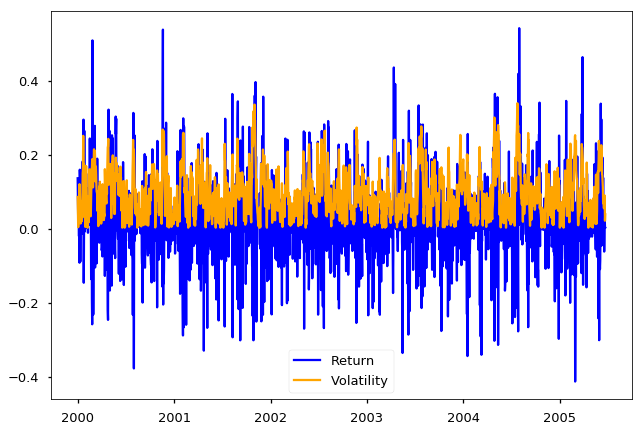

In [23]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [24]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.003756,-0.000100
rtn,-0.000100,0.011448


In [25]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

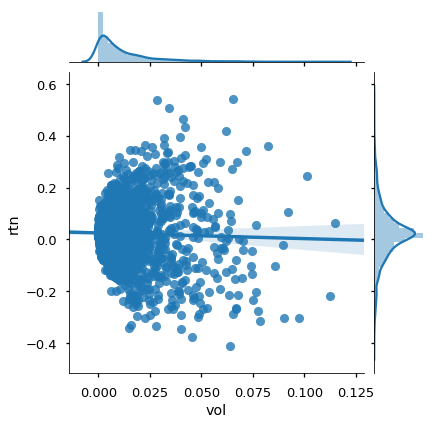

In [26]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [27]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.012340,0.022455
std,0.015314,0.106994
min,0.000010,-0.411834
25%,0.002064,-0.028553
50%,0.006839,0.021523
75%,0.016945,0.069611
max,0.114747,0.541122


## I now estimate all of the parameters

In [28]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [29]:
vl.compute_init_constants(data.vol)

{'log_both': -6.003000418535995,
 'log_scale': -5.570900169473591,
 'logit_rho': 1.3837075525029123}

In [30]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [31]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [32]:
vl.compute_init_constants(data.vol)

{'log_both': -6.003000418535995,
 'log_scale': -5.570900169473591,
 'logit_rho': 1.3837075525029123}

In [33]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -5.988658628330563,
  'log_scale': -5.576381876506402,
  'logit_rho': 1.4982611372271104},
            log_both  log_scale  logit_rho
 log_both   0.006502   0.001051  -0.006511
 log_scale  0.001051   0.001810  -0.000648
 logit_rho -0.006511  -0.000648   0.016647)

In [34]:
# with Pool(8) as pool:
#     est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.compute_vol_gmm, [data.vol for data in data_arr]),
#                                       total=len(data_arr)))

In [35]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [36]:
# ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
#             for est in est_arr]

In [37]:
# vol_fig, vol_ax = mpl.pyplot.subplots()
# sns.distplot(ar_stats, ax=vol_ax)
# vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
# vol_ax.set_xlim([0,20])
# vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
# vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [38]:
# 100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

In [39]:
# t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
#             for est in est_arr for name in ['logit_rho', 'log_scale', 'log_both']]
# t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [40]:
# true_params['log_both']

In [41]:
# np.amin([est[0]['log_both'] for est in est_arr])

In [42]:
# t_stats_df.describe()

In [43]:
# for name, col in t_stats_df.items():
#     fig, ax = mpl.pyplot.subplots()
#     sns.distplot(col, ax=ax)
#     ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
#     ax.set_xlim([-4,4])

In [44]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [45]:
estimator(data_arr[0])

({'gamma': 0.012453398782314103,
  'beta': 3.9799265554871113,
  'psi': -3.514298869104027,
  'zeta': 0.8135595701782845,
  'log_both': -5.988658628330563,
  'log_scale': -5.576381876506402,
  'logit_rho': 1.4982611372271104,
  'phi': -0.4,
  'pi': -4.006362233103521,
  'theta': 1.7385566994162094},
                beta         gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.011015 -2.354548e-05  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000024  2.206689e-07  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000e+00  0.006502   0.001051  -0.006511       NaN   
 log_scale  0.000000  0.000000e+00  0.001051   0.001810  -0.000648       NaN   
 logit_rho  0.000000  0.000000e+00 -0.006511  -0.000648   0.016647       NaN   
 phi             NaN           NaN       NaN        NaN        NaN  0.001041   
 pi              NaN           NaN       NaN        NaN        NaN -0.404524   
 psi       -0.009370  8.089809e-06  0.000000   0.000000   0

In [46]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [47]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [48]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

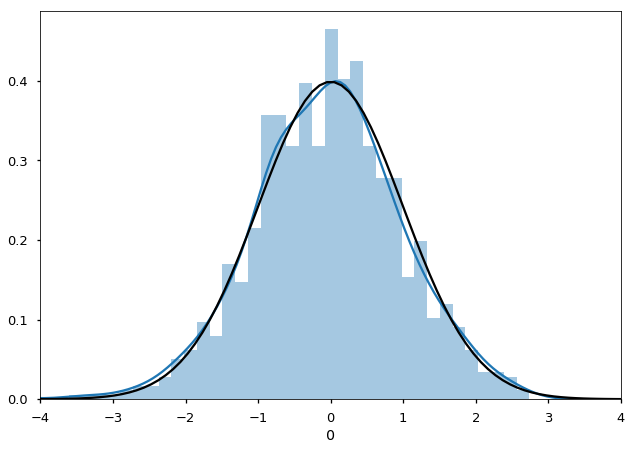

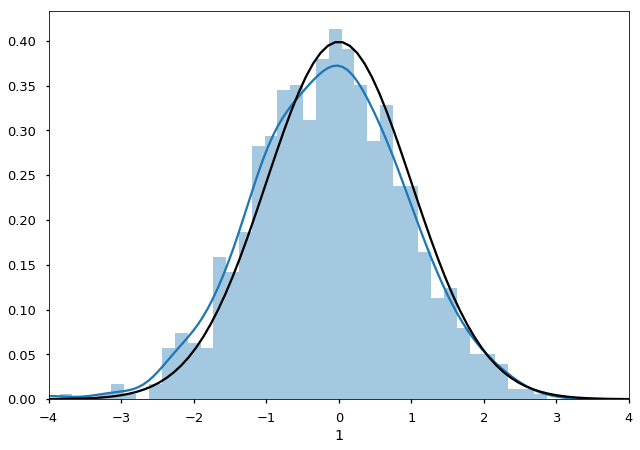

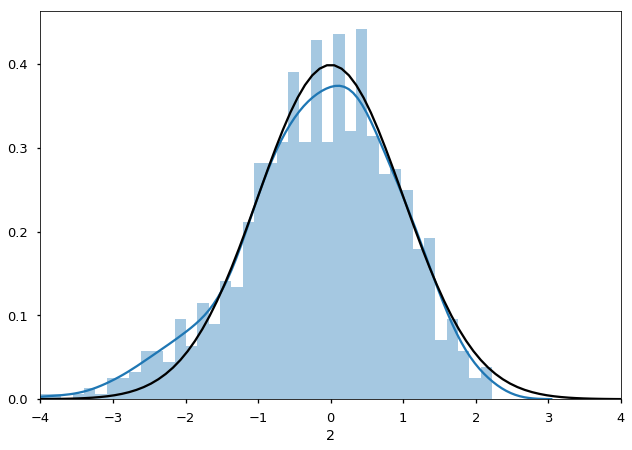

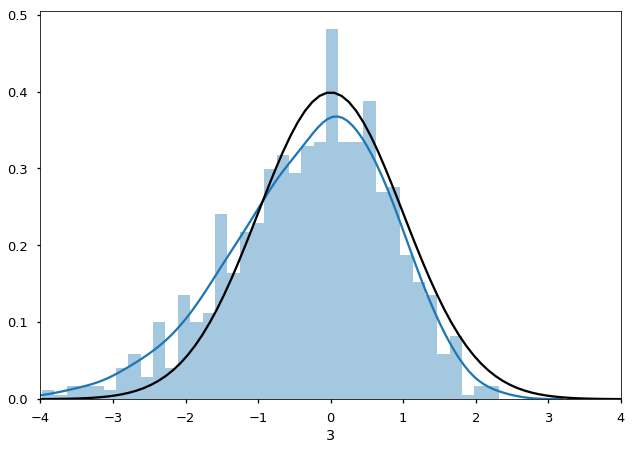

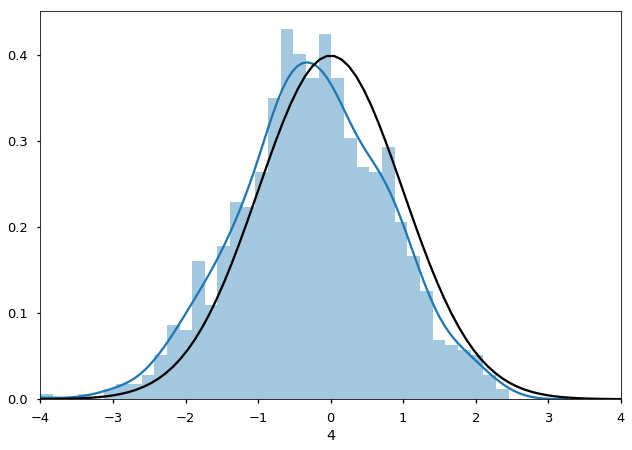

In [49]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [50]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

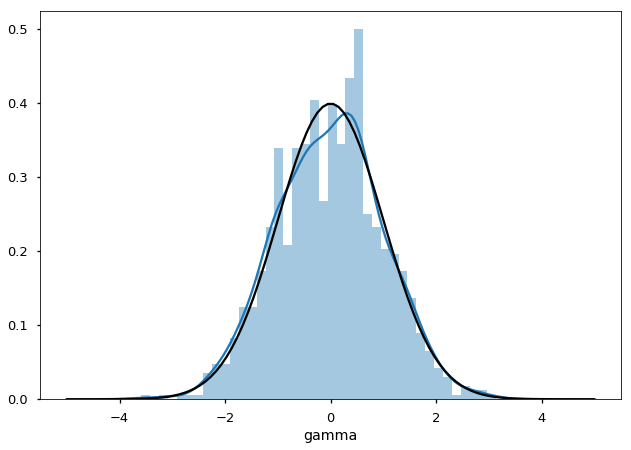

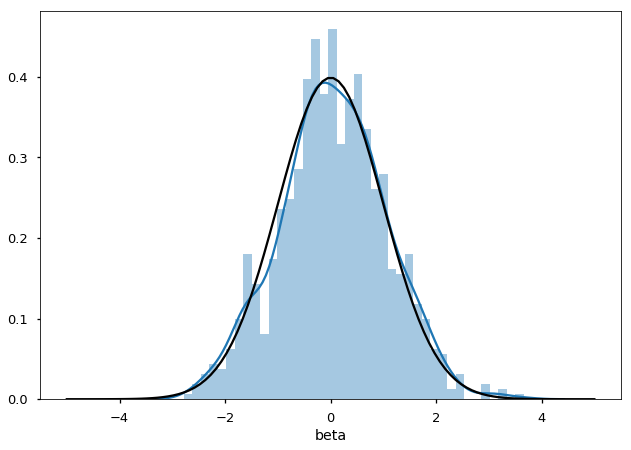

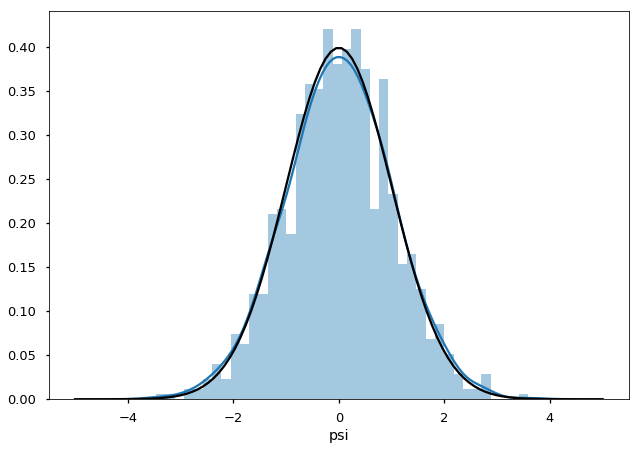

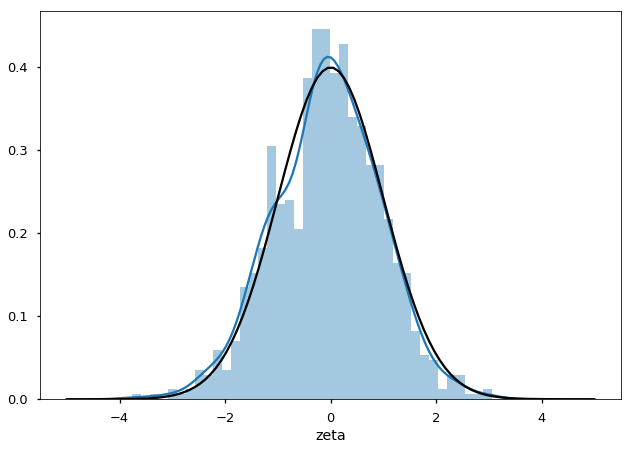

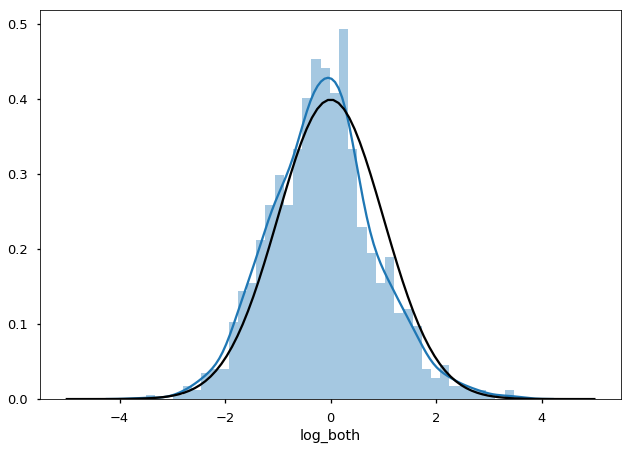

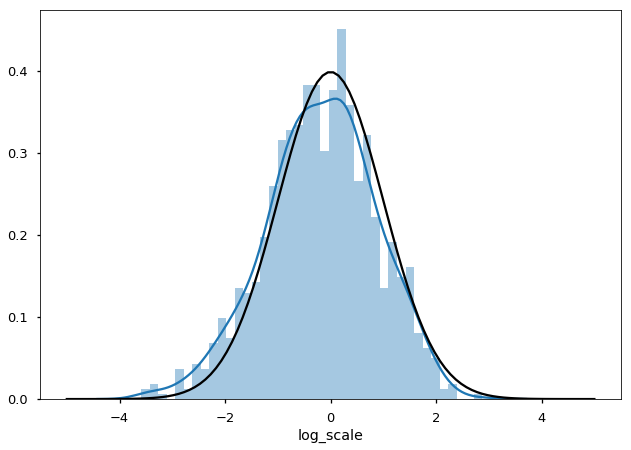

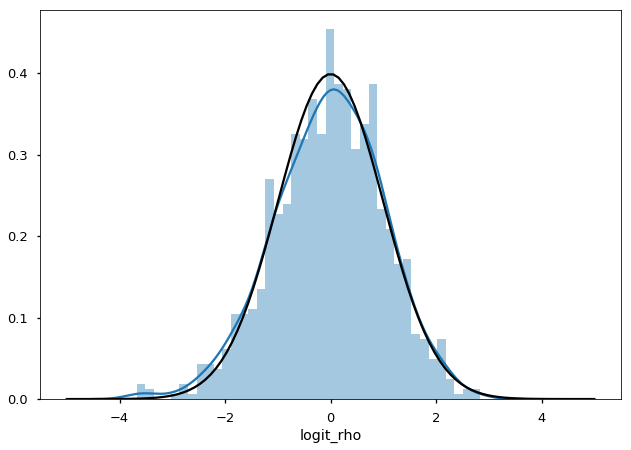

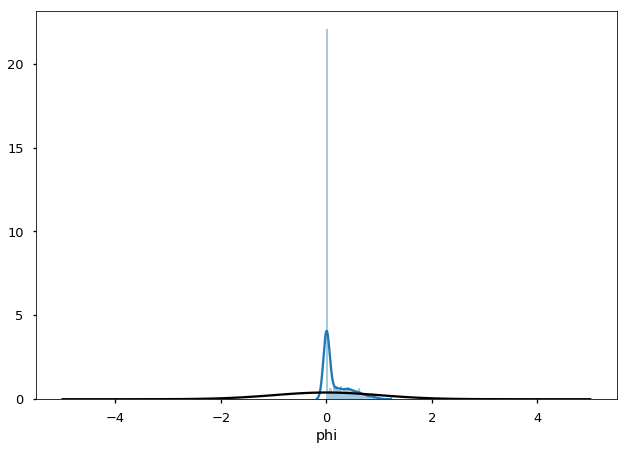

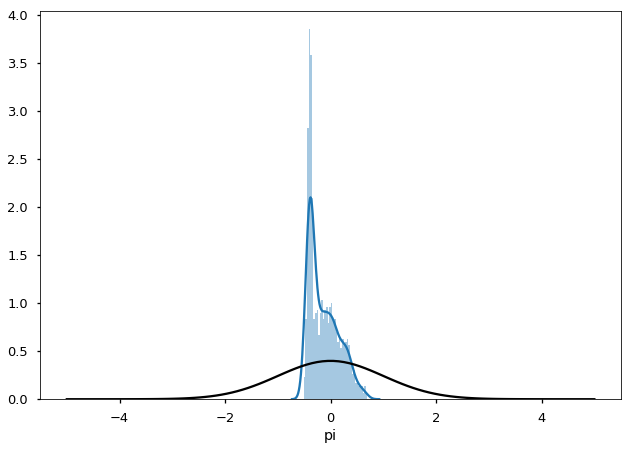

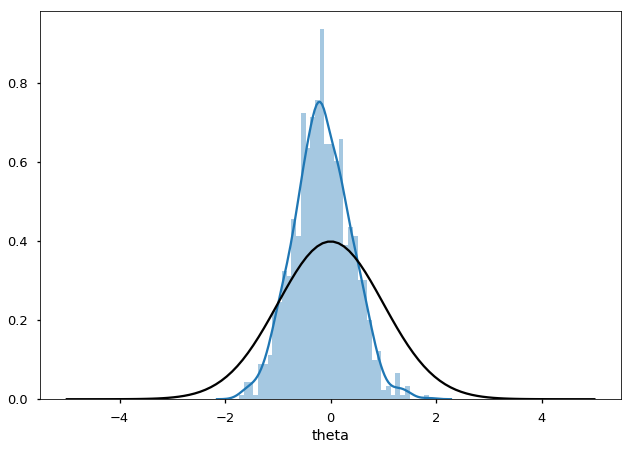

In [51]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

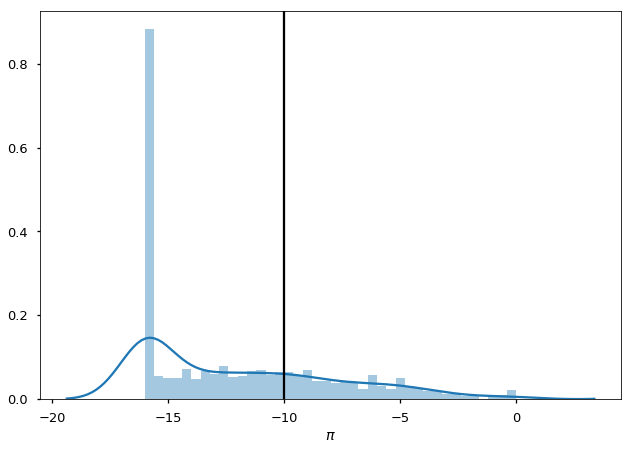

In [52]:
fig, ax = mpl.pyplot.subplots()       
sns.distplot(pd.Series([est['pi'] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
ax.axvline(total_true_params['pi'], color='black')
ax.set_xlabel('$\pi$')
fig.savefig('../doc/figures/pi_est_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
                        frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [53]:
omega


{'gamma': 0.012392604028109261,
 'beta': 4.0603617597333646,
 'psi': -3.2506706683970314,
 'zeta': 0.8597904208657579,
 'log_both': -6.036213645436284,
 'log_scale': -5.575091722235095,
 'logit_rho': 1.4204468026880561}

In [54]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [55]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [56]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [84]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [85]:
compute_ar(est_arr[0])

2.285437480298326

In [86]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

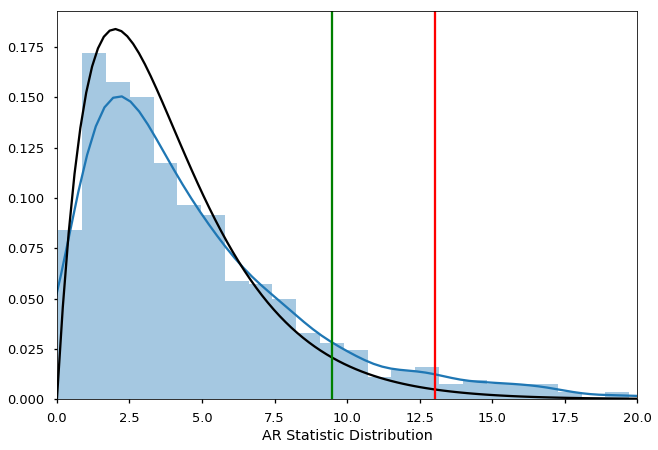

In [87]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [83]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

PicklingError: Can't pickle <function <lambda> at 0x7f08eec00c80>: attribute lookup <lambda> on __main__ failed

In [62]:
 stats.chi2.ppf(df=4, q=.95)

9.487729036781154

In [63]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

0    11.4
dtype: float64

In [64]:
# results[results <=0] = 0 

In [88]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [66]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [67]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [72]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [73]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,1.713384,6.602327,False,False
1,6.336797,6.603116,False,False
2,0.345255,6.521868,False,False
3,0.880003,6.610414,False,False
4,0.957177,6.212219,False,False


In [74]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,1.713384,6.602327,False,False
1,6.336797,6.603116,False,False
2,0.345255,6.521868,False,False
3,0.880003,6.610414,False,False
4,0.957177,6.212219,False,False


In [75]:
returnval.mean()

qlr_stat               2.994092
robust_qlr_qauntile    5.195622
robust                 0.187000
standard               0.080000
dtype: float64

In [76]:
true_params['phi']

-0.4

In [77]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [78]:
returnval.mean()

qlr_stat               2.994092
robust_qlr_qauntile    5.195622
robust                 0.187000
standard               0.080000
dtype: float64

In [79]:
returnval.query('robust_qlr_qauntile > 0').mean()

qlr_stat               2.994092
robust_qlr_qauntile    5.195622
robust                 0.187000
standard               0.080000
dtype: float64

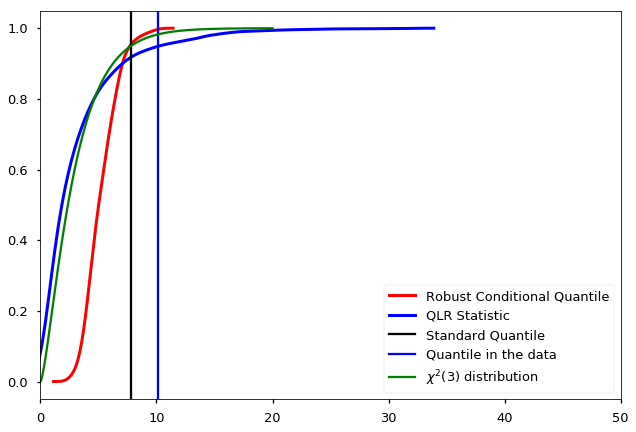

In [80]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)